# Face recognition - training and prediction

Lets pick from where we left. We've extracted about 200 Principal components from the set of images with 4096 pixels/features however we don't need all the 200 components to recognize a face. From the previous notebook we could recognize some random faces with as low as 60 components accurately however we need a number that would maximize the prediction accuracy. Lets create few models and train them to predict the faces. We will then evaluate the train and test accuracy of each model.


In [1]:
# Import library / packages

# For numerical operation
import numpy as np

# Pandas for tabular manipulations
import pandas as pd

# For plots
from matplotlib import pyplot as plt

# Support Vector Machine
from sklearn.svm import SVC

# K-Nearest Neighbour
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the data (saved from previous note book )
X_train = np.load("Result01\X_train.npy", )
X_test = np.load("Result01\X_test.npy")
Y_train = np.load("Result01\Y_train.npy")
Y_test = np.load("Result01\Y_test.npy")
Weight_train = np.load("Result01\Weight_train.npy")
Weight_test = np.load("Result01\Weight_test.npy")
Eigen_val = np.load("Result01\Eigen_val.npy")
Eigen_vec = np.load("Result01\Eigen_vec.npy")
Mean_face =np.load("Result01\Mean_face.npy")

## Function to find the minimum number of components that maximizes our prediction

In [3]:
# Train the model and plot the accuracy
def model_find_components(model, W_train, Y_train, W_test, Y_test, plot = 'Y', step=1) :
    Train_pred = np.array([]); Test_pred = np.array([])
    for i in range(0,W_train.shape[1],step) :
        
        # Filter components
        X_train = W_train[:,0:i+1]
        X_test = W_test[:,0:i+1]
                
        # Train the model        
        model.fit(X_train,Y_train.ravel())
    
        # Predict the result        
        Y_train_pred = model.predict(X_train)
        Y_test_pred = model.predict(X_test)
        Train_pred = np.append(Train_pred,np.sum(Y_train_pred.reshape(-1) == Y_train.reshape(-1))*100/Y_train.shape[0])
        Test_pred = np.append(Test_pred,np.sum(Y_test_pred.reshape(-1) == Y_test.reshape(-1))*100/Y_test.shape[0])
        
    if plot == 'Y' :
        plt.figure(figsize=(20,8))
        plt.plot(Train_pred, label = 'Train', color = 'green')
        plt.plot(Test_pred, label = 'Test', color = 'red')
        plt.legend()
        plt.xlabel('Components', fontsize=15)
        plt.ylabel('Accuracy', fontsize=15)
        plt.title('Accuracy of model prediction vs Number of components')
        plt.show()
    
    return(Train_pred, Test_pred)
    

## Model - Predict class (face) using distance of weight vector from class mean

The original paper that talks about face recognition using PCA or Eigen faces, use the distance method to predict. It uses Euclidean distance as well as Mahalanobis for prediction. The link to paper is given below and we would create a model class that tries to find the distance () of weight vectors for each training and test dataset, from the class mean. There are 40 different faces in the dataset hence 40 classes.

http://www.face-rec.org/algorithms/PCA/jcn.pdf



In [8]:
class Dist_mod :
    
    def __init__(self,typ='eu') :
        assert(typ in ['eu', 'mh'])
        self.typ = typ
        
    def fit(self,X,Y) :
                    
        # Find mean weights by class
        self.W_mean = pd.concat([pd.DataFrame(Y, columns = ['Label']), pd.DataFrame(X)], axis = 1)\
                                .groupby(['Label']).mean().values

        # Find std weights by class
        if self.typ == 'mh' :
            # Find std weights by class
            self.W_std = pd.concat([pd.DataFrame(Y, columns = ['Label']), pd.DataFrame(X)], axis = 1)\
                                .groupby(['Label']).std().values
            
            # Find class - using min mahalanobis distance
            self.out = self._mh_classdist(X, self.W_mean, self.W_std)
        
        elif self.typ == 'eu' :
            # Find class - using min euclidean distance
            self.out = self._eu_classdist(X, self.W_mean)
        
        # Maximum allowed distance from vector
        self.max_dist = np.max(self.out[:,1])
            
            
    # Find euclidean distance from each class
    def _eu_classdist(self,X,Mean) :
        distance = np.empty([X.shape[0], Mean.shape[0]])   
        for i, mean in enumerate(Mean) :            
            distance[:,i] = np.linalg.norm((X-mean.reshape(1,-1)), axis=1)  
        output = np.vstack((np.argmin(distance, axis = 1),np.min(distance, axis = 1))).T
        return(output)
    
    
    # Find mahalanobis distance from each class
    def _mh_classdist(self,X,Mean,std) :
        distance = np.empty([X.shape[0], Mean.shape[0]])     
        for i, mean in enumerate(Mean) :
            norm_vec = ((X-mean.reshape(1,-1))/std[i,:])        
            distance[:,i] = np.linalg.norm(norm_vec, axis=1)          
        output = np.vstack((np.argmin(distance, axis = 1),np.min(distance, axis = 1))).T    
        return(output)

            
    def predict(self,X, check_dist='Y', extr_dist='N') :
        if self.typ == 'eu' :
            # Predict class - using min euclidean distance
            self.out = self._eu_classdist(X, self.W_mean)
            
        elif self.typ == 'mh' :
            # Predict class - using min mahalanobis distance
            self.out = self._mh_classdist(X, self.W_mean, self.W_std)
        
        if check_dist == 'Y' :
            self.out[np.where(self.out[:,1] > self.max_dist),0] = np.nan
        
        if extr_dist == 'Y' :
            return(self.out[:,0],self.out[:,1])
        else :
            return(self.out[:,0])
    
    
    
        
    

## Train and Predict - without mirror faces


In [9]:
Train_out = dict(); Test_out = dict()

In [10]:
# Model to predict class based on euclidean distance of weights from mean of each class
model = Dist_mod(typ='eu')
Train_out['DISTEU'], Test_out['DISTEU'] = model_find_components(model, \
                                            Weight_train[0:280,:], Y_train[0:280,:], Weight_test, Y_test, plot = 'N')

In [11]:
# Model to predict class based on euclidean distance of weights from mean of each class
model = Dist_mod(typ='mh')
Train_out['DISTMH'], Test_out['DISTMH'] = model_find_components(model, \
                                            Weight_train[0:280,:], Y_train[0:280,:], Weight_test, Y_test, plot = 'N')

In [12]:
# Support vector machine (RBF kernel)
model = SVC(kernel='rbf', gamma='auto')
Train_out['SVCRBF'], Test_out['SVCRBF'] = model_find_components(model, \
                                            Weight_train[0:280,:], Y_train[0:280,:], Weight_test, Y_test, plot = 'N')

In [13]:
# KNN model (Euclidean distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
Train_out['KNN1EU'], Test_out['KNN1EU'] = model_find_components(model,\
                                            Weight_train[0:280,:], Y_train[0:280,:], Weight_test, Y_test, plot = 'N')

In [14]:
# KNN model (Mahalanobis distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
W_train = Weight_train / np.sqrt(Eigen_val)
W_test = Weight_test / np.sqrt(Eigen_val)
Train_out['KNN1MH'], Test_out['KNN1MH'] = model_find_components(model,\
                                            W_train[0:280,:], Y_train[0:280,:], W_test, Y_test, plot = 'N')

In [15]:
Method = dict()
Method['SVCRBF'] = 'SVC RBF (Weights)'
Method['DISTEU'] = 'Class Mean EU distance'
Method['DISTMH'] = 'Class Mean MH distance'
Method['KNN1EU'] = 'KNN 1 neigbour and EU distance (Weights)'
Method['KNN1MH'] = 'KNN 1 neigbour and MH distance (Weights)'

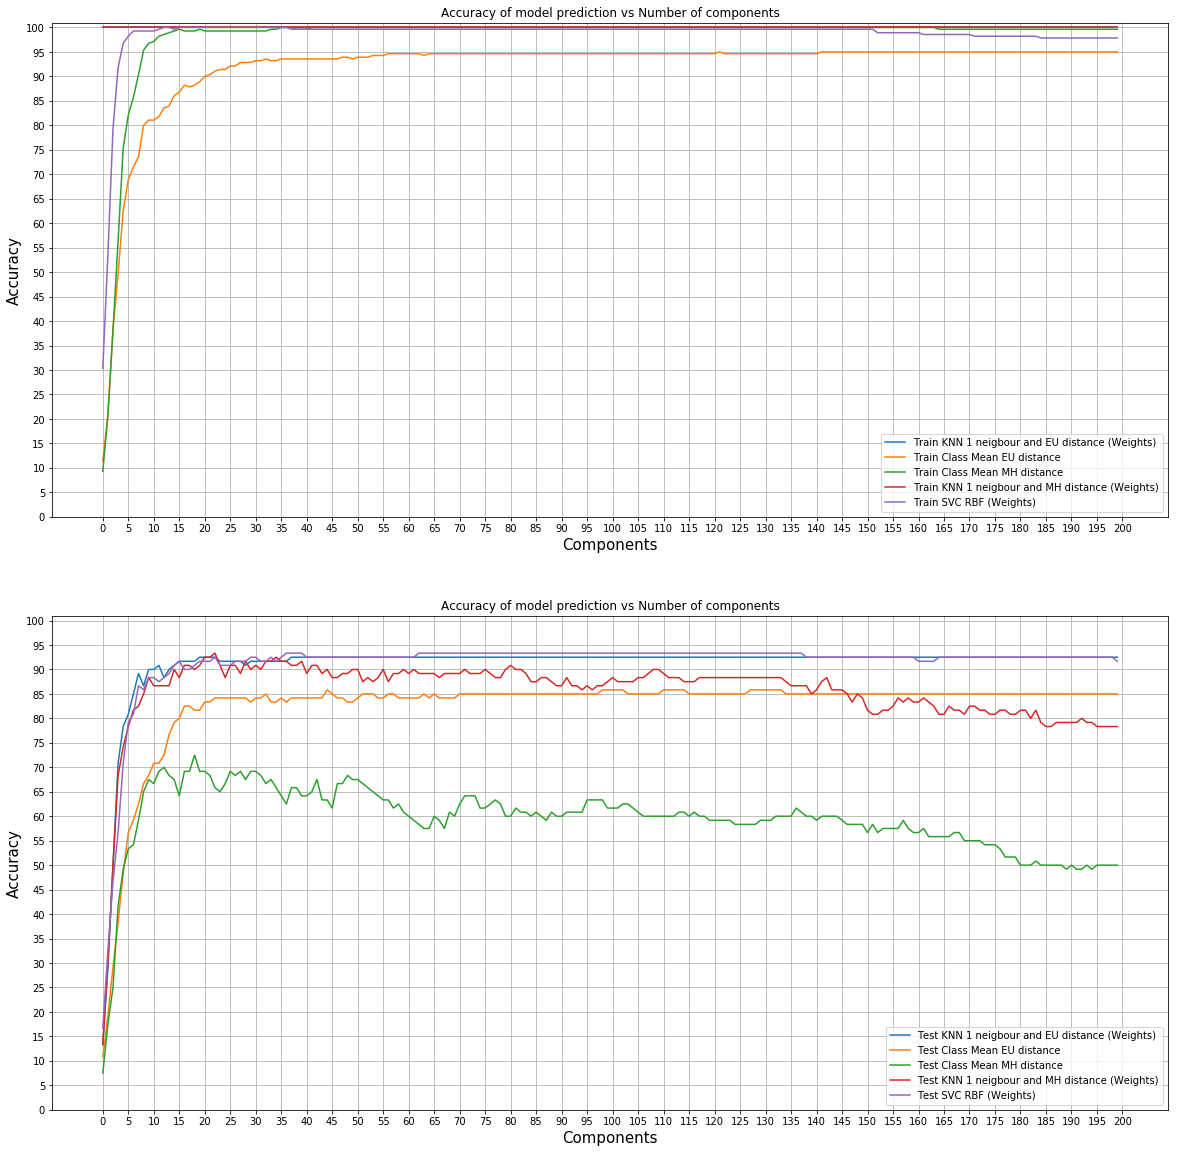

In [16]:
# Plot all output
fig, axes = plt.subplots(2,1,figsize=(20,20))

for i, ax in enumerate(axes.flat) :
    for key in Train_out.keys():
        if i == 0 :
            ax.plot(Train_out[key], label = 'Train ' + Method[key])            
        else :
            ax.plot(Test_out[key], label = 'Test '+ Method[key])

    ax.legend(loc = 'lower right')
    ax.set_xlabel('Components', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_title('Accuracy of model prediction vs Number of components')
    ax.set_ylim(0,101)
    ax.set_yticks(np.arange(0,101,5))
    ax.set_xticks(np.arange(0,201,5))
    ax.grid()

    
plt.show()


## Train and Predict - with mirror faces

In [17]:
Train_out = dict(); Test_out = dict()

In [18]:
# Model to predict class based on euclidean distance of weights from mean of each class
model = Dist_mod(typ='eu')
Train_out['DISTEU'], Test_out['DISTEU'] = model_find_components(model, \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [19]:
# Model to predict class based on euclidean distance of weights from mean of each class
model = Dist_mod(typ='mh')
Train_out['DISTMH'], Test_out['DISTMH'] = model_find_components(model, \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [20]:
# Support vector machine (RBF kernel)
model = SVC(kernel='rbf', gamma='auto')
Train_out['SVCRBF'], Test_out['SVCRBF'] = model_find_components(model, \
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [21]:
# KNN model (Euclidean distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
Train_out['KNN1EU'], Test_out['KNN1EU'] = model_find_components(model,\
                                            Weight_train, Y_train, Weight_test, Y_test, plot = 'N')

In [22]:
# KNN model (Mahalanobis distance and 1 neighbour)
model = KNeighborsClassifier(n_neighbors=1)
W_train = Weight_train / np.sqrt(Eigen_val)
W_test = Weight_test / np.sqrt(Eigen_val)
Train_out['KNN1MH'], Test_out['KNN1MH'] = model_find_components(model,\
                                            W_train, Y_train, W_test, Y_test, plot = 'N')

In [23]:
Method = dict()
Method['SVCRBF'] = 'SVC RBF (Weights)'
Method['DISTEU'] = 'Class Mean EU distance'
Method['DISTMH'] = 'Class Mean MH distance'
Method['KNN1EU'] = 'KNN 1 neigbour and EU distance (Weights)'
Method['KNN1MH'] = 'KNN 1 neigbour and MH distance (Weights)'

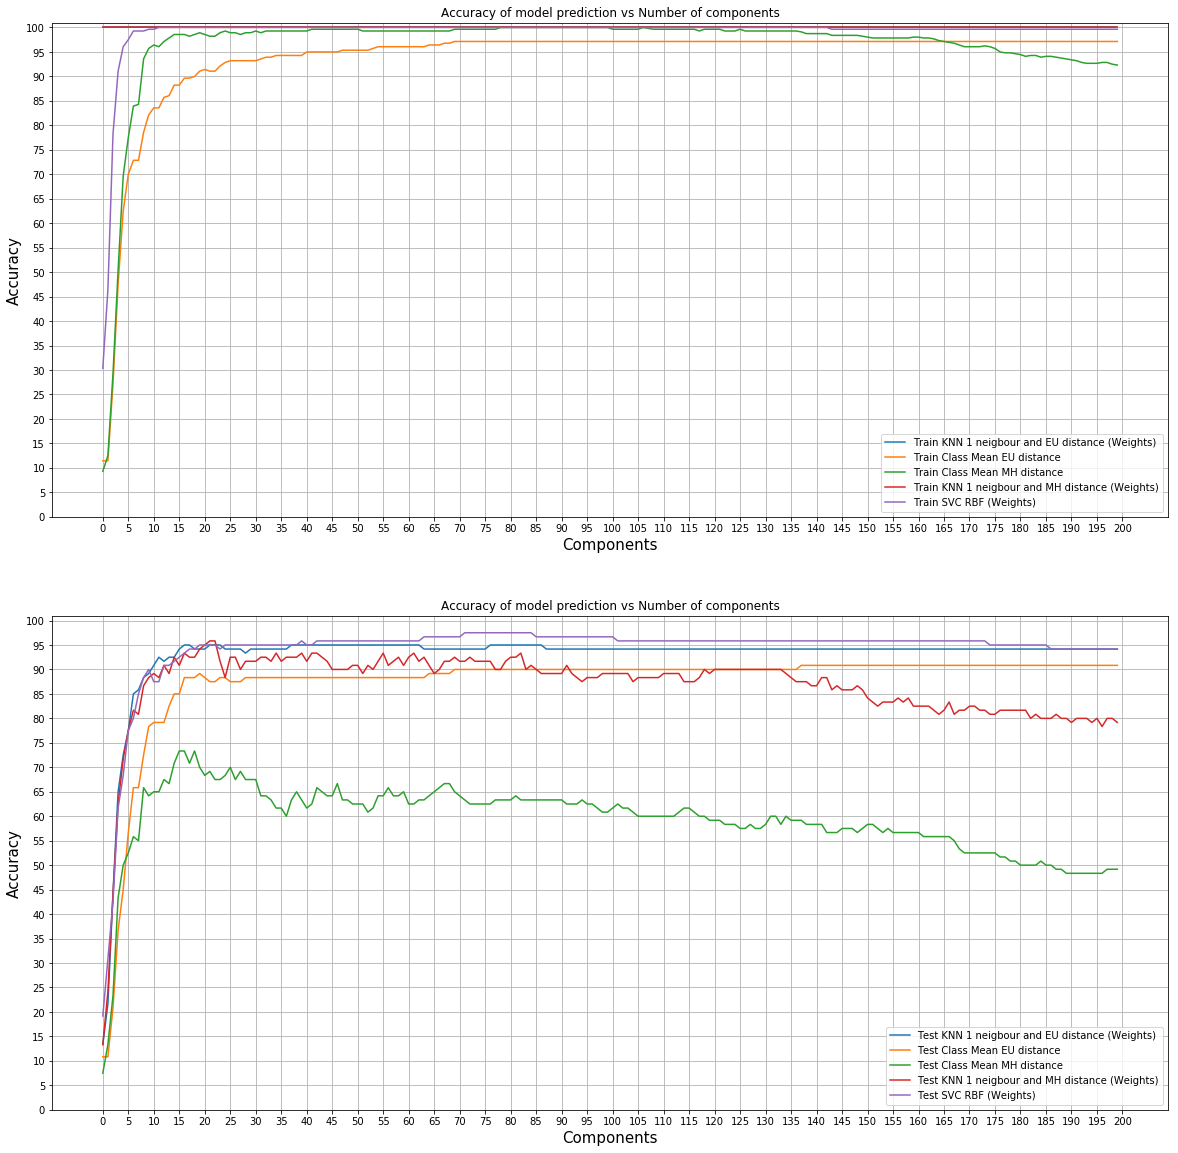

In [24]:
# Plot all output
fig, axes = plt.subplots(2,1,figsize=(20,20))

for i, ax in enumerate(axes.flat) :
    for key in Train_out.keys():
        if i == 0 :
            ax.plot(Train_out[key], label = 'Train ' + Method[key])            
        else :
            ax.plot(Test_out[key], label = 'Test '+ Method[key])

    ax.legend(loc = 'lower right')
    ax.set_xlabel('Components', fontsize=15)
    ax.set_ylabel('Accuracy', fontsize=15)
    ax.set_title('Accuracy of model prediction vs Number of components')
    ax.set_ylim(0,101)
    ax.set_yticks(np.arange(0,101,5))
    ax.set_xticks(np.arange(0,201,5))
    ax.grid()

plt.show()


## Pick 2 models and, train and predict on random dataset

In [74]:
# Ramdom data
Z1 = np.random.random([10,64,64])
Z2 = np.random.random([10,64,64])/10

In [76]:
# Find Weights
Weight_Z1 = np.dot(Z1.reshape(10,-1),Eigen_vec[0:75,:].T)
Weight_Z2 = np.dot(Z2.reshape(10,-1),Eigen_vec[0:75,:].T)

In [77]:
# Final 2 models
model01 = SVC(kernel='rbf', gamma='auto')
model01.fit(Weight_train[:,0:75], Y_train.ravel())

model02 = Dist_mod(typ='eu')
model02.fit(Weight_train[:,0:75], Y_train.ravel())

In [78]:
# Prediction
Y_Z101 = model01.predict(Weight_Z1)
Y_Z102 = model02.predict(Weight_Z1,check_dist='Y',extr_dist='Y')

Y_Z201 = model01.predict(Weight_Z2)
Y_Z202 = model02.predict(Weight_Z2,check_dist='Y',extr_dist='Y')

In [79]:
# Check results (Z1)
pd.DataFrame(np.vstack((Y_Z101,Y_Z102)).T)

,0,1,2
0,7.0,NaN,23.253985
1,7.0,NaN,22.999383
2,7.0,NaN,23.019707
3,7.0,NaN,23.189986
4,7.0,NaN,23.162084
5,7.0,NaN,22.705465
6,7.0,NaN,23.209988
7,7.0,NaN,22.874169
8,7.0,NaN,23.249075
9,7.0,NaN,23.175179


In [80]:
# Check results (Z2)
pd.DataFrame(np.vstack((Y_Z201,Y_Z202)).T)

,0,1,2
0,12.0,22.0,3.341659
1,12.0,22.0,3.327781
2,12.0,22.0,3.316869
3,12.0,22.0,3.319654
4,12.0,3.0,3.364070
5,12.0,22.0,3.340831
6,12.0,22.0,3.332718
7,12.0,22.0,3.322566
8,12.0,22.0,3.353033
9,12.0,22.0,3.281807


In [84]:
np.sum(Weight_test[:,0:75] - np.dot(X_test,Eigen_vec[0:75,:].T))
#np.dot(X_test,Eigen_vec[0:75,:].T).shape

1582.958777060453

# Final model

In [25]:
# Final model
model = SVC(kernel='rbf', gamma='auto')

# Pick 60 components
W_train = Weight_train[:,0:75]
W_test = Weight_test[:,0:75]

# Train the model
model.fit(W_train,Y_train.ravel())
    
# Predict the result
Y_train_pred = model.predict(W_train)
Y_test_pred = model.predict(W_test)

print("Train Accuracy : {} and Test Accuracy {}"\
      .format((np.sum(Y_train_pred.reshape(-1) == Y_train.reshape(-1))*100/Y_train.shape[0]), \
      np.sum(Y_test_pred.reshape(-1) == Y_test.reshape(-1))*100/Y_test.shape[0]))



Train Accuracy : 100.0 and Test Accuracy 97.5


## Faces that failed prediction

In [26]:
# Regenerate faces (that failed prediction)

# No of faces that failed detection
fail_count = np.sum(Y_test_pred.reshape(-1) != Y_test.reshape(-1))

failed_faces = list()
for i, _ in enumerate(Y_test_pred.reshape(-1)) :
    if Y_test_pred.reshape(-1)[i] != Y_test.reshape(-1)[i] :
        failed_faces.append(i)



In [27]:
# Failed pred table
pd.DataFrame(np.vstack((Y_test[failed_faces,:].ravel(),Y_test_pred[failed_faces])).T, columns=['Actual', 'Prediction'])

,Actual,Prediction
0,7,0
1,21,38
2,9,7


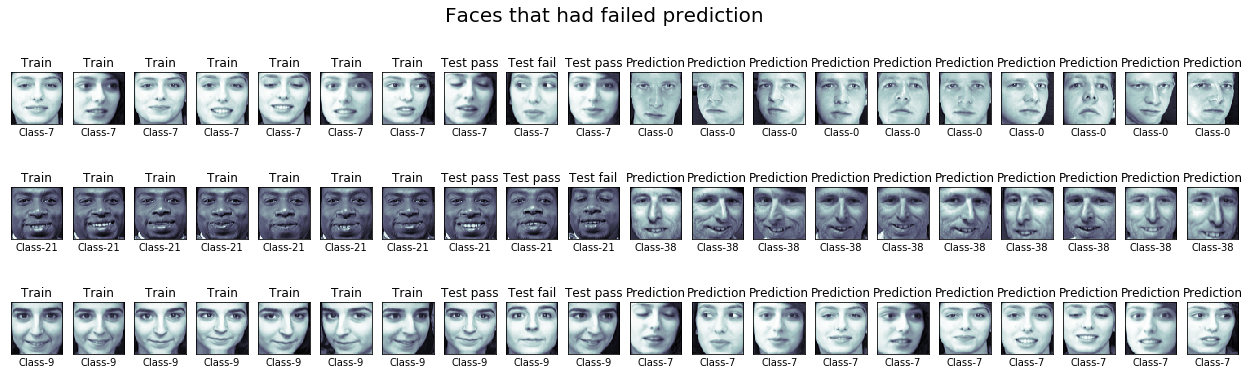

In [28]:
# View all the failed faces + the prediction
fig, axes = plt.subplots(fail_count,20,figsize=(22,(fail_count)*2),\
                            subplot_kw = {'xticks':[],'yticks':[]})

plt.suptitle('Faces that had failed prediction', fontsize = 20)

ax = axes.flat
j = 0

for Y in Y_test[failed_faces,:].ravel() :
    
    fail = -9
    for i,Y1 in enumerate(Y_train[0:280,:].ravel()) :
        if Y1 == Y :
            ax[j].imshow(X_train[i,:].reshape(64,64), cmap = 'bone')
            title = "Train"
            ax[j].set_title(title)
            ax[j].set_xlabel('Class-' + str(Y))
            j += 1
            
    for i,Y1 in enumerate(Y_test.ravel()) :
        if Y1 == Y :
            ax[j].imshow(X_test[i,:].reshape(64,64), cmap = 'bone')        
            if i in failed_faces :
                title = "Test fail"
                fail = i
            else :
                title = "Test pass"
            ax[j].set_title(title)
            ax[j].set_xlabel('Class-' + str(Y))
            j += 1
            

    Y2 = Y_test_pred[fail] 
    for i,Y1 in enumerate(Y_test.ravel()) :
        if Y1 == Y2 :
            ax[j].imshow(X_test[i,:].reshape(64,64), cmap = 'bone')        
            title = "Prediction"
            ax[j].set_title(title)
            ax[j].set_xlabel('Class-' + str(Y2))
            j += 1
    
             
    for i,Y1 in enumerate(Y_train[0:280,:].ravel()) :
        if Y1 == Y2 :
            ax[j].imshow(X_train[i,:].reshape(64,64), cmap = 'bone')
            title = "Prediction"
            ax[j].set_title(title)
            ax[j].set_xlabel('Class-' + str(Y2))
            j += 1



In [161]:
X_test[40,:].mean()

0.6362638

In [162]:
X_test[109,:].mean()

0.38230908

In [164]:
np.sort(np.array([X_test[i,:].mean() for i in range(120)]))

array([0.38230908, 0.39493984, 0.40593928, 0.40709844, 0.40853706,
       0.40921095, 0.41561815, 0.42654294, 0.43501523, 0.43577588,
       0.43714288, 0.45218375, 0.46395293, 0.47954667, 0.4796496 ,
       0.47986752, 0.48406932, 0.48552507, 0.48679924, 0.48819044,
       0.4901678 , 0.49143693, 0.49207354, 0.4984464 , 0.5020439 ,
       0.5021922 , 0.5022931 , 0.5048344 , 0.505471  , 0.5070397 ,
       0.5108057 , 0.5110146 , 0.51104385, 0.51160574, 0.5132421 ,
       0.5137536 , 0.51671255, 0.51996607, 0.52764845, 0.53139627,
       0.5322115 , 0.5342977 , 0.5366786 , 0.5371578 , 0.5375432 ,
       0.5381969 , 0.5400431 , 0.5406    , 0.5415261 , 0.5415947 ,
       0.54359525, 0.5451045 , 0.54588026, 0.5467217 , 0.5469416 ,
       0.54735726, 0.54742885, 0.5488211 , 0.5488614 , 0.5503747 ,
       0.55039084, 0.55106676, 0.5511808 , 0.55287564, 0.5535617 ,
       0.55446154, 0.5546663 , 0.559423  , 0.55952287, 0.5598669 ,
       0.56239104, 0.56315374, 0.5634907 , 0.5639467 , 0.56423